In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Machine learning algorithms

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Modelling Helpers :
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

#preprocessing :
from sklearn.preprocessing import MinMaxScaler , StandardScaler, LabelEncoder

#evaluation metrics :
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score 

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline


# 1. Data Exploration

In [ ]:
df=pd.read_csv('diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
#removing 'Unamed : 0' as it's acting same as S.NO
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df.head(1)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43


column 'Unnamed: 0' is succesfully removed

In [ ]:
df.shape

(53940, 10)

here we can see that our dataset has 53940 rows and 10 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


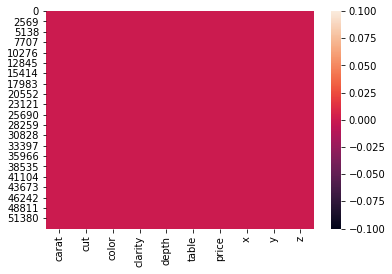

In [ ]:
df.info()
sns.heatmap(df.isnull())

we don't have any missing values so we don't need to clean our data

In [ ]:
#let's see some statistical information about data
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


here we can see that columns x,y and z have some values as 0 which is not possible as the dimensions of the diamond can't be 0 , so we'll drop them

In [ ]:
df.loc[(df['x']==0) | (df['y']==0) | (df['z']==0)].shape

(20, 10)

we 20 diamonds with 0 dimensions

In [ ]:
df = df[(df[['x','y','z']] != 0).all(axis=1)]

In [ ]:
df.loc[(df['x']==0) | (df['y']==0) | (df['z']==0)]

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z


all rows with 0 dimensions are dropped , nice!

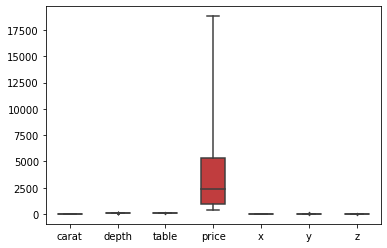

In [ ]:

sns.boxplot(data=df,width=0.5,fliersize=2, whis=10)

here we can see that our values are distributed over small scale except price which is our target feature

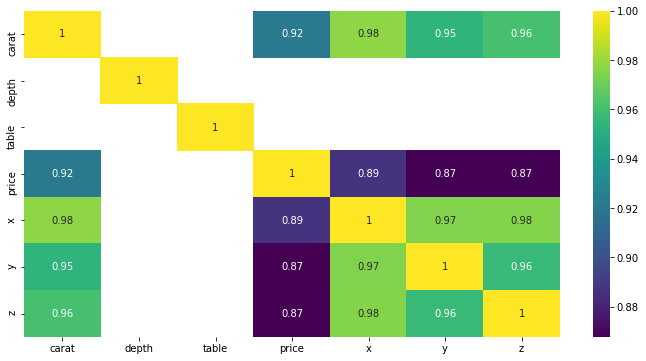

In [ ]:
# let's visualize the features which have high correlation(>70) 
plt.figure(figsize=(12,6))
corr=df.corr()
sns.heatmap(corr[(corr >= 0.50) | (corr <= -0.50)],annot=True,cmap='viridis')

here we can observe from the heatmap that price is strongly correlated with the dimensions of the diamond (bigger and heavier the diamond ,more expensive it is) that is columns x,y and z,it's also highly correlated to carat

# 2.Visualizing Features

In [ ]:
fig = px.scatter(df, x="carat", y="price")
fig.show()

we can see from the graph that carat varies with price exponetially


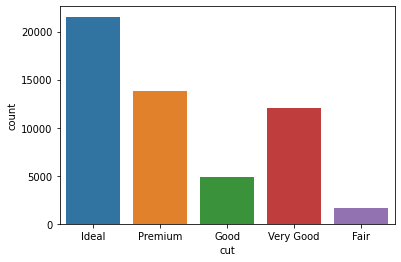

In [ ]:
sns.countplot(x='cut',data=df)

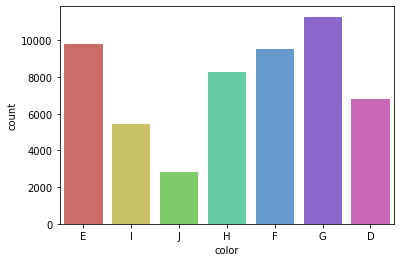

In [ ]:
sns.countplot(x='color',data=df,palette='hls')

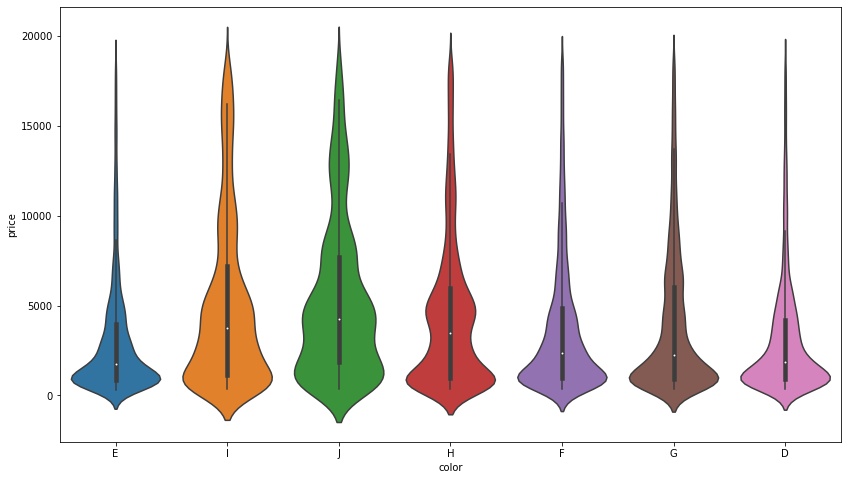

In [ ]:
plt.figure(figsize=(14,8))
sns.violinplot(data=df,x='color',y='price',inner='box',scale='width')

In [ ]:
names = df.clarity.unique().tolist()
values = df.clarity.value_counts().tolist()
fig= px.pie(df, values=values,names=names,title='Percentage of clarity categories')
fig.show()

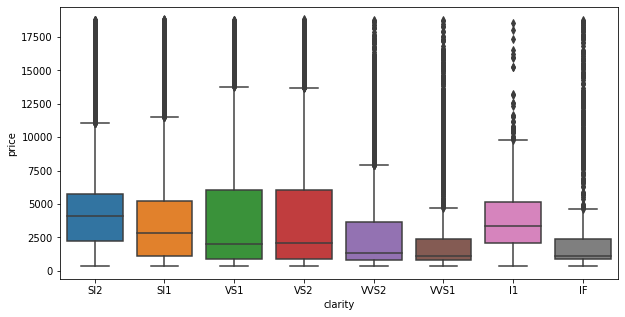

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='clarity', y='price', data=df )

we can see that VS1 and VS2 affect the prices almost equally

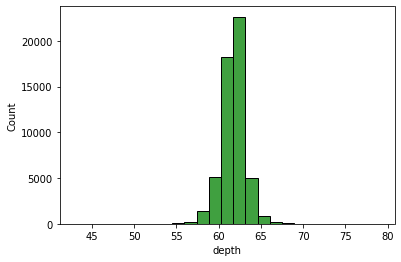

In [ ]:
sns.histplot(data=df,x='depth',bins=25,color='green')

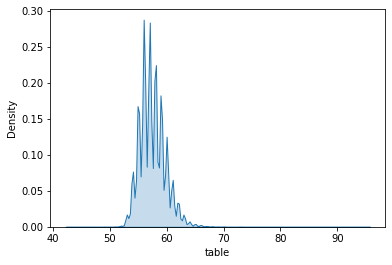

In [ ]:
sns.kdeplot(data=df,x='table',shade=True)

(1.0, 9.0)

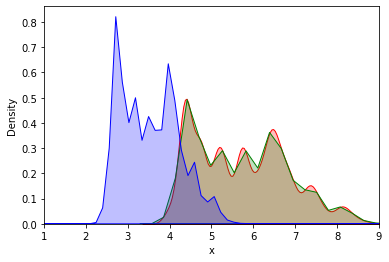

In [ ]:
sns.kdeplot(df['x'] ,shade=True , color='r' )
sns.kdeplot(df['y'] , shade=True , color='g' )
sns.kdeplot(df['z'] , shade= True , color='b')
plt.xlim(1,9)

# 3. Feature Engineering

As the dimensions x,y and z don't help much in feature explaination so let's combine them in 'volume' to simplify the model

In [ ]:
df['volume']=df.x*df.y*df.z
df.head(3)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885


(0.0, 50000.0)

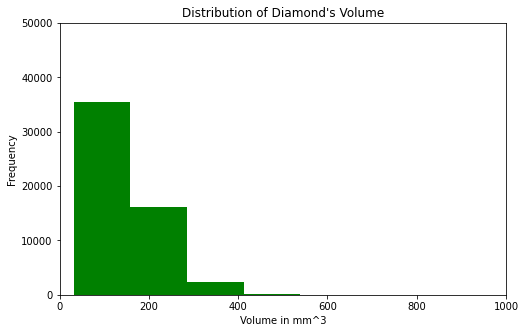

In [ ]:
plt.figure(figsize=(8,5))
plt.hist( x=df['volume'] , bins=30 ,color='g')
plt.xlabel('Volume in mm^3')
plt.ylabel('Frequency')
plt.title('Distribution of Diamond\'s Volume')
plt.xlim(0,1000)
plt.ylim(0,50000)

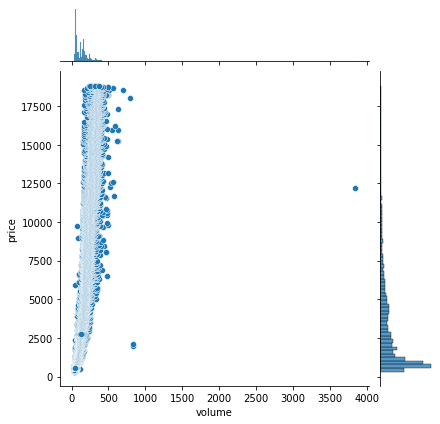

In [ ]:
sns.jointplot(data=df,x='volume',y='price',size=6)

this shows that volume and price have linear relationship between them



dropping columns x,y and z as we don't need them now as we got volume to fulfill them


In [ ]:
df.drop(['x','y','z'],axis=1,inplace=True)

In [ ]:
# labelling the categorical features with digits
label_cut = LabelEncoder()
label_color = LabelEncoder()
label_clarity = LabelEncoder()


df['cut'] = label_cut.fit_transform(df['cut'])
df['color'] = label_color.fit_transform(df['color'])
df['clarity'] = label_clarity.fit_transform(df['clarity'])

In [ ]:
df.head()

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,2,1,3,61.5,55.0,326,38.202030
1,0.21,3,1,2,59.8,61.0,326,34.505856
2,0.23,1,1,4,56.9,65.0,327,38.076885
3,0.29,3,5,5,62.4,58.0,334,46.724580
4,0.31,1,6,3,63.3,58.0,335,51.917250


In [ ]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)


In [ ]:
# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 4. Modelling and implementing algorithms

In [ ]:
R2_Scores = []
models = ['Linear Regression', 'RandomForest Regression', 'KNeighbours Regression','AdaBoost Regression' , 'GradientBoosting Regression']

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train , y_train)
accuracies = cross_val_score(estimator = lin_reg, X = X_train, y = y_train, cv = 10)
y_pred = lin_reg.predict(X_test)
print('')
print('     Linear Regression      ')
print('Score : %.4f' % lin_reg.score(X_test, y_test))
print( accuracies)
print('Mean score: %0.3f'% accuracies.mean())

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)
print('')
print('MSE    : %0.2f ' % mse)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)
R2_Scores.append(r2)



     Linear Regression      
Score : 0.8822
[0.86291451 0.87503302 0.87948694 0.88238964 0.87431836 0.87234056
 0.87732277 0.884338   0.88690258 0.877165  ]
Mean score: 0.877

MSE    : 1859120.27 
RMSE   : 1363.50 
R2     : 0.88 


In [ ]:
# Random Forrest
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train , y_train)
accuracies = cross_val_score(estimator = clf_rf, X = X_train, y = y_train, cv = 10)
y_pred = clf_rf.predict(X_test)
print('')
print('     Random Forest     ')
print('Score : %.4f' % clf_rf.score(X_test, y_test))
print(accuracies)
print('Mean: %0.3f' % accuracies.mean())

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)
print('')
print('MSE    : %0.2f ' % mse)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)
R2_Scores.append(r2)



     Random Forest     
Score : 0.9999
[0.99980545 0.99984916 0.99996512 0.99991571 0.99996246 0.99995317
 0.99979256 0.99991786 0.99994095 0.99996762]
Mean: 1.000

MSE    : 1618.65 
RMSE   : 40.23 
R2     : 1.00 


NameError: ignored

In [ ]:
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

NameError: ignored

In [ ]:
# K Nearest Neighbors
knn = KNeighborsRegressor()
knn.fit(X_train , y_train)
accuracies = cross_val_score(estimator = knn, X = X_train, y = y_train, cv = 5)
y_pred = knn.predict(X_test)
print('')
print('      KNeighbours Regression      ')
print('Score : %.4f' % knn.score(X_test, y_test))
print(accuracies)
print('Mean %0.3f' %accuracies.mean())

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

R2_Scores.append(r2)




      KNeighbours Regression      
Score : 0.9555
[0.95550427 0.94967073 0.950604   0.9552312  0.95491678]
Mean 0.953

MSE    : 701687.03 
MAE    : 440.00 
RMSE   : 837.67 
R2     : 0.96 


In [ ]:
# Ada Boost
ada = AdaBoostRegressor(n_estimators=100)
ada.fit(X_train , y_train)
accuracies = cross_val_score(estimator = ada, X = X_train, y = y_train, cv = 5)
y_pred = ada.predict(X_test)
print('')
print('      AdaBoost Regression      ')
print('Score : %.4f' % ada.score(X_test, y_test))
print(accuracies)
print('Mean: %0.3f' %accuracies.mean())

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)
R2_Scores.append(r2)



      AdaBoost Regression      
Score : 0.8696
[0.88297213 0.8782608  0.87349556 0.88337213 0.87840452]
Mean: 0.879

MSE    : 2058358.62 
RMSE   : 1434.70 
R2     : 0.87 


In [ ]:
# GRadient Boost Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=1, random_state=0, loss='ls')
gbr.fit(X_train , y_train)
accuracies = cross_val_score(estimator = gbr, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = gbr.predict(X_test)
print('')
print('      Gradient Boosting Regression      ')
print('Score : %.4f' % gbr.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)
R2_Scores.append(r2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



      Gradient Boosting Regression      
Score : 0.9069
[0.90574973 0.90437992 0.89846863 0.90751984 0.9039695 ]

MSE    : 1469016.40 
RMSE   : 1212.03 
R2     : 0.91 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s finished


In [ ]:
compare = pd.DataFrame({'Algorithms' : models , 'R2-Scores' : R2_Scores})
compare.sort_values(by='R2-Scores' ,ascending=False)

,Algorithms,R2-Scores
1,RandomForest Regression,0.980314
2,KNeighbours Regression,0.955531
4,GradientBoosting Regression,0.906902
0,Linear Regression,0.882180
3,AdaBoost Regression,0.869553


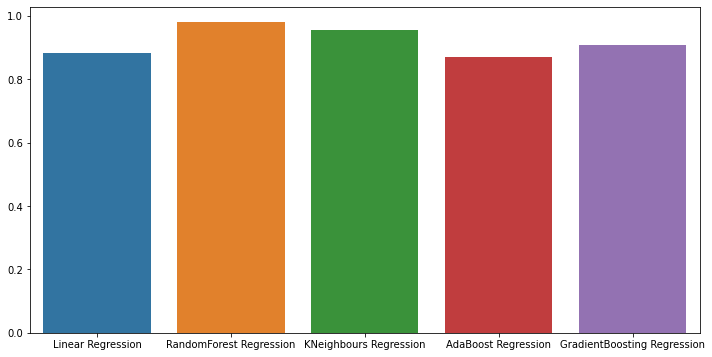

In [ ]:
# Let's try to visualize the accuracy of the algorithms too
plt.figure(figsize=(12,6))
sns.barplot(data=compare,x=models,y=R2_Scores)

here we can see that Random Forrest regressor gives us the best accuracy so it is the best model for our dataset
